# Labeling the whole dataset

In [38]:
import pandas as pd
import numpy as np


In [39]:
cleaned_df = pd.read_csv('/Users/sabrinasayed/Documents/GitHub/Data_Center_Sites/Cleaned Data/Merged_Data.csv', index_col=0)
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2979 entries, 0 to 2978
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   City                                 2979 non-null   object 
 1   State                                2979 non-null   object 
 2   Total Generation Rank                2979 non-null   object 
 3   Electric Generation Rank             2979 non-null   object 
 4   Commercial Generation Rank           2979 non-null   object 
 5   Capacity Growth Status               2979 non-null   object 
 6   CAIDI w/ Major Events                2979 non-null   float64
 7   CAIDI w/o Major Events               2979 non-null   float64
 8   SAIFI Major Events                   2979 non-null   object 
 9   Utility Annual Energy Savings (MWh)  2979 non-null   object 
 10  Utility Peak Demand Savings (MW)     2979 non-null   object 
 11  Utility Annual Incentive Cost ($)  

In [40]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from gower import gower_matrix

In [41]:
X = cleaned_df


# One-Hot Encoding for Categorical Features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = encoder.fit_transform(cleaned_df)
feature_names = encoder.get_feature_names_out()

inertia = []
silhouette_scores = []
clusters = range(2, 11)

for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(encoded_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(encoded_data, kmeans.labels_))

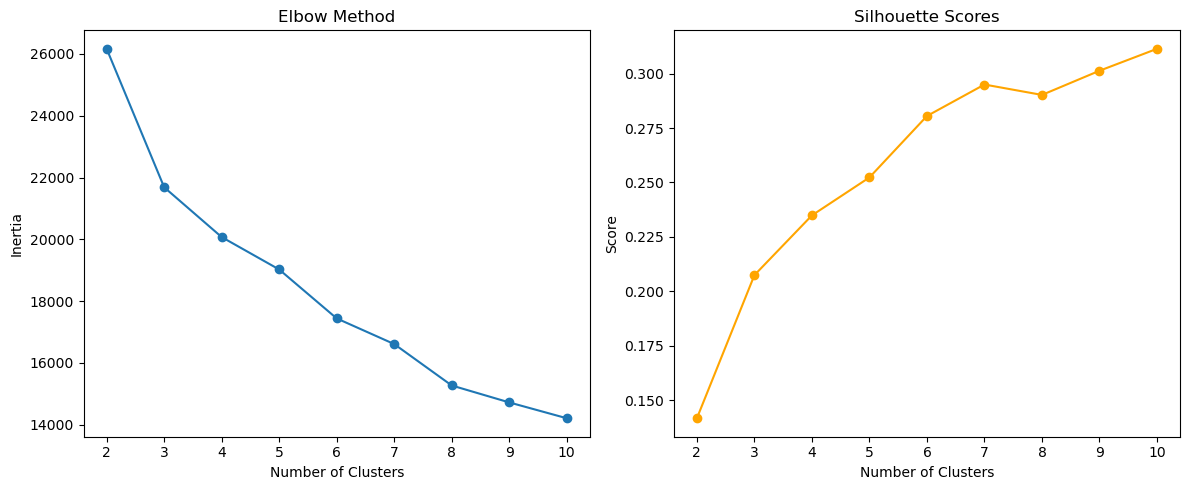

In [42]:
# Plot Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(clusters, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

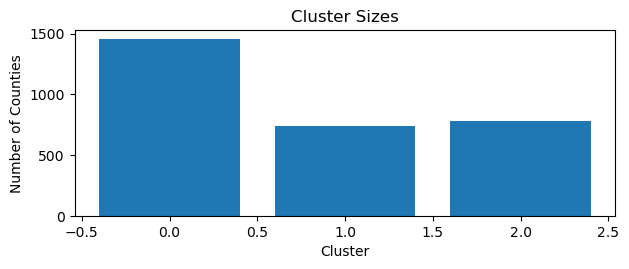

In [43]:

# Select optimal number of clusters (based on elbow/silhouette)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data)

# Add cluster labels to original dataframe
cleaned_df['Cluster'] = cluster_labels

# Analyze cluster characteristics
plt.subplot(2, 2, (3, 4))
cluster_sizes = cleaned_df['Cluster'].value_counts().sort_index()
plt.bar(range(optimal_clusters), cluster_sizes)
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Counties')

plt.tight_layout()
plt.show()

In [44]:
# Print cluster characteristics
print("\nCluster Analysis:")
print("-" * 50)

for cluster in range(optimal_clusters):
    cluster_data = cleaned_df[cleaned_df['Cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_data)} counties)")
    print("-" * 30)
    
    # Analyze categorical features
    for col in cleaned_df.select_dtypes(include=['object']).columns:
        if col != 'Cluster':
            print(f"\n{col}:")
            print(cluster_data[col].value_counts().head(3))
            
    # Calculate feature importance
    cluster_center = kmeans.cluster_centers_[cluster]
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(cluster_center)
    }).sort_values('Importance', ascending=False)
    
    print("\nTop distinguishing features:")
    print(feature_importance.head(5))
    print("\n" + "="*50)



Cluster Analysis:
--------------------------------------------------

Cluster 0 (1457 counties)
------------------------------

City:
City
New York    180
Denver      130
Seattle     102
Name: count, dtype: int64

State:
State
NY    200
FL    140
CO    130
Name: count, dtype: int64

Total Generation Rank:
Total Generation Rank
High        666
Moderate    466
Unknown     192
Name: count, dtype: int64

Electric Generation Rank:
Electric Generation Rank
Moderate    737
High        321
Low         207
Name: count, dtype: int64

Commercial Generation Rank:
Commercial Generation Rank
High        638
Moderate    358
Low         269
Name: count, dtype: int64

Capacity Growth Status:
Capacity Growth Status
Growing      868
Shrinking    397
Unknown      192
Name: count, dtype: int64

SAIFI Major Events:
SAIFI Major Events
Moderate    819
Low         626
High         12
Name: count, dtype: int64

Utility Annual Energy Savings (MWh):
Utility Annual Energy Savings (MWh)
Low         889
High       

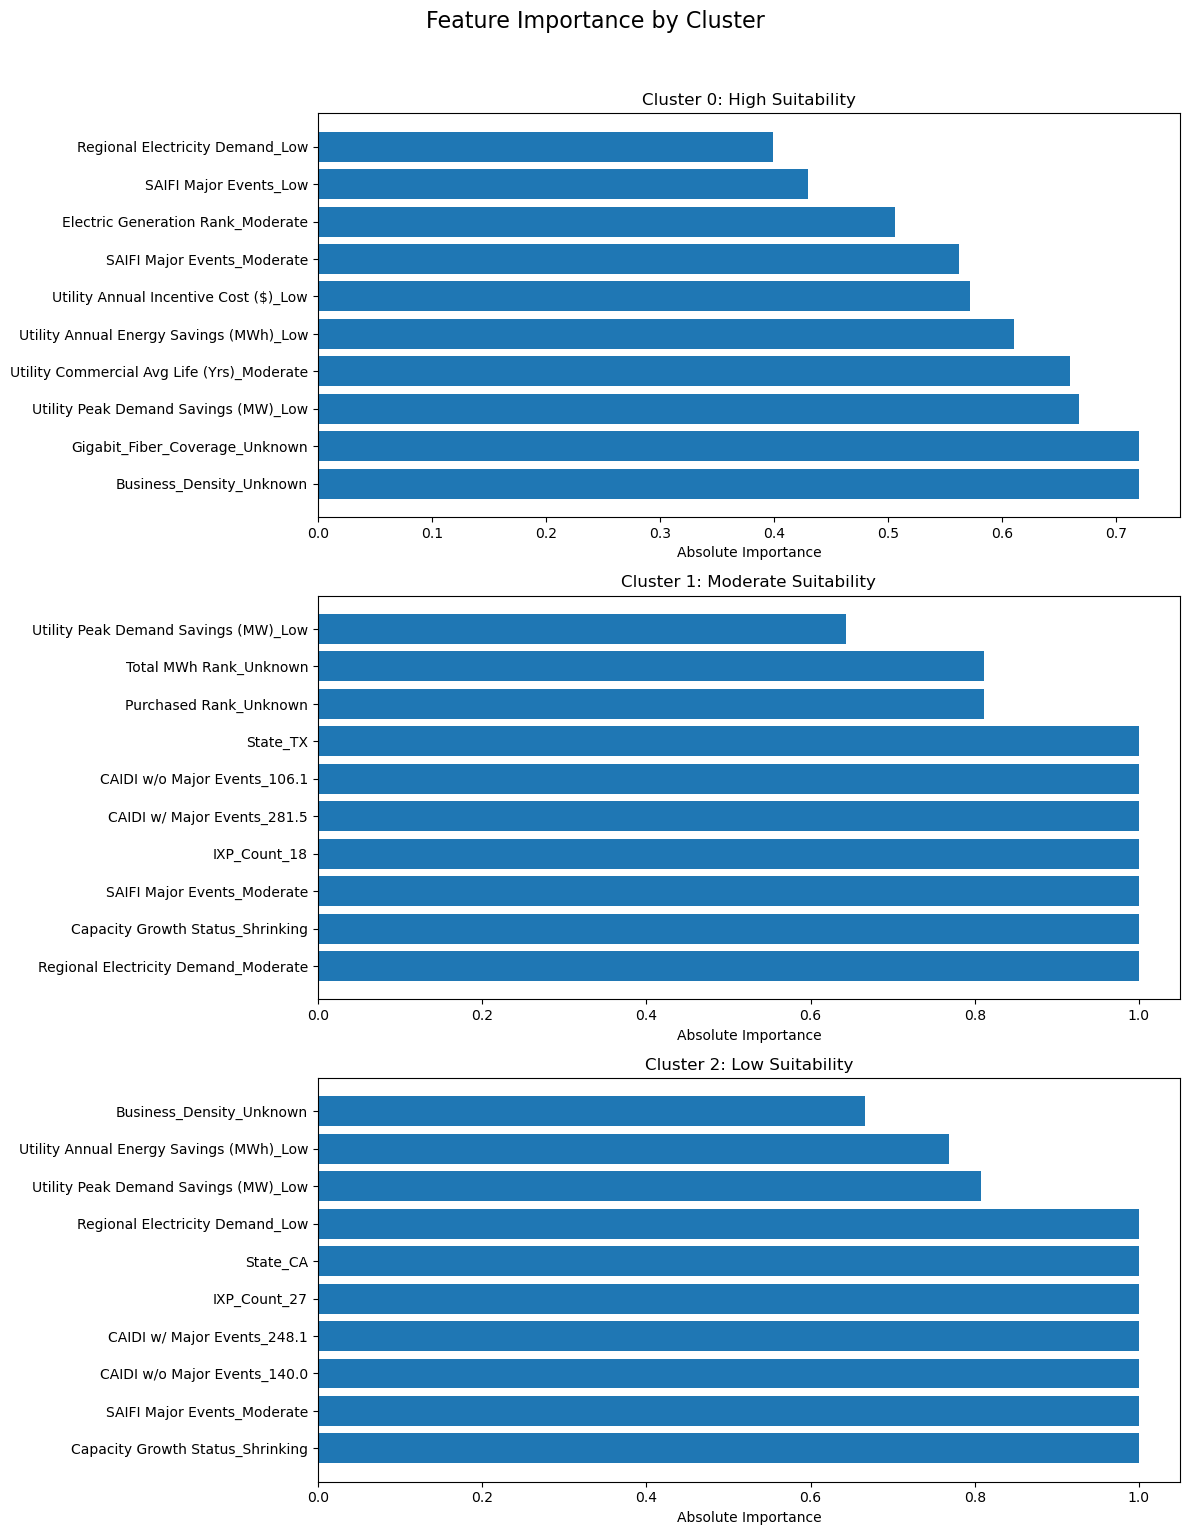

In [50]:
# Create a figure with subplots for each cluster
fig, axes = plt.subplots(optimal_clusters, 1, figsize=(12, 5*optimal_clusters))
fig.suptitle('Feature Importance by Cluster', fontsize=16, y=1.02)

for cluster in range(optimal_clusters):
    # Get cluster center and create feature importance DataFrame
    cluster_center = kmeans.cluster_centers_[cluster]
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(cluster_center)
    }).sort_values('Importance', ascending=False).head(10)  # Show top 10 features
    
    # Create horizontal bar plot
    axes[cluster].barh(feature_importance['Feature'], feature_importance['Importance'])
    axes[cluster].set_title(f'Cluster {cluster}: {suitability_mapping[cluster]}')
    axes[cluster].set_xlabel('Absolute Importance')
    
plt.tight_layout()
plt.show()

# Cluster Distinguishing Features

Cluster 0 : High Suitability
- Growing Capacity
- Moderate Interruption
- Low Cost
- Low Demand
- Excellent Fiber Coverage

Cluster 1 : Moderate Suitability
- Shrinking Capacity
- Moderate Interruption
- Moderate Cost
- Moderate Demand
- Good Fiber Coverage

Cluster 2 : Low Suitability
- Shrinking Capacity
- Moderate Interruption
- Limited Fiber Coverage


# Mapping Clusters to Target Variable labels

In [46]:
# Create a mapping dictionary for cluster to suitability labels
suitability_mapping = {
    0: 'High Suitability',
    1: 'Moderate Suitability',
    2: 'Low Suitability'
}

# Add the Suitability column based on the cluster mapping
cleaned_df['Suitability'] = cleaned_df['Cluster'].map(suitability_mapping)

# Verify the distribution of suitability labels
print("\nSuitability Distribution:")
print(cleaned_df['Suitability'].value_counts())


Suitability Distribution:
Suitability
High Suitability        1457
Low Suitability          780
Moderate Suitability     742
Name: count, dtype: int64


In [48]:
cleaned_df.drop(columns=['Cluster'], inplace=True)

In [49]:
# Save the labeled dataset
cleaned_df.to_csv('/Users/sabrinasayed/Documents/GitHub/Data_Center_Sites/Cleaned Data/Labeled_Data.csv')